# Optically-dark short GRBs

## Imports/loading/setup

In [1]:
%load_ext autoreload
%autoreload 2

In [81]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, importlib
from astropy.io import votable, ascii
from scipy import interpolate

from selenium import webdriver
from selenium.webdriver.support.wait import WebDriverWait

from custom_utils import AsymmetricUncertainty, custom_iter

alpha = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
alpha += alpha.lower()
numeric = ".0123456789"
calc_code = importlib.import_module("Calculation Code.main")
graph_code = importlib.import_module("Graphing Code.Graphing_Beta_OX")

In [3]:
swift = pd.read_html("https://swift.gsfc.nasa.gov/archive/grb_table/fullview/")[0] # get latest Swift catalog
swift.columns = [col[0] for col in swift.columns] # reduce/flatten MultiIndex
sGRBs = swift[swift["BAT T90[sec]"].apply(pd.to_numeric, errors="coerce") <= 2].copy() # filter catalog for GRBs with a valid T90 that is <2s

## Data parsing and cleanup

In [4]:
# format columns
sGRBs.drop(['Time[UT]', 'BAT RA(J2000)', 'BAT Dec(J2000)', 'BAT 90%Error Radius[arcmin]',
            'BAT Fluence(15-150 keV)[10-7 erg/cm2]', 'BAT Fluence90% Error(15-150 keV)[10-7 erg/cm2]',
            'BAT 1-sec PeakPhoton Flux(15-150 keV)[ph/cm2/sec]', 'BAT 1-sec PeakPhoton Flux90% Error(15-150 keV)[ph/cm2/sec]',
            'BAT Photon Index(15-150 keV)(PL = simple power-law,CPL = cutoff power-law)', 'BAT Photon Index90% Error(15-150 keV)',
            'XRT RA(J2000)', 'XRT Dec(J2000)', 'XRT 90%Error Radius[arcsec]', 'XRT Column Density(NH)[1021 cm-2]',
            'XRT Early Flux(0.3-10 keV)[10-11 erg/cm2/s]', 'XRT 11 Hour Flux(0.3-10 keV)[10-11 erg/cm2/s]',
            'XRT 24 Hour Flux(0.3-10 keV)[10-11 erg/cm2/s]', 'UVOT RA(J2000)', 'UVOT Dec(J2000)', 'UVOT 90%Error Radius[arcsec]',
            'Host Galaxy', 'Comments', 'References', 'Burst Advocate'],axis=1,inplace=True) # already in master catalog
sGRBs.rename(columns={'XRT Time to FirstObservation[sec]':'XRT dt [sec]',
                      'UVOT Time toFirst Observation[sec]':'UVOT dt [sec]',
                      'UVOT Other FilterMagnitudes':'Other UVOT Filters'},inplace=True)

mags = pd.Series([],dtype=float) # numerical magnitudes
lims = pd.Series([],dtype=object) # what kind of limit?
for idx,mag in sGRBs["UVOT Magnitude"].iteritems():
    #print(idx)
    try:
        mags[idx] = float(mag)
        lims[idx] = "equal"
    except ValueError:
        if ">" in mag:
            lims[idx] = "brightest"
            mags[idx] = float("".join([char for char in mag.split()[0] if char in "0123456789."]))
        elif "=" in mag:
            lims[idx] = "equal"
            mags[idx] = float("".join([char for char in mag.split()[0] if char in "0123456789."]))
        else:
            print(mag)
            lims[idx] = "equal"
            mags[idx] = np.nan

sGRBs["UVOT Vmag"] = mags
sGRBs["UVOT Vmag lim"] = lims

See GCN 10184


In [5]:
def split_filters(string):
    UVOT_filters = ["B","U","UVW1","UVM2","UVW2","White"]
    name_idxs = custom_iter([string.index(i) for i in UVOT_filters if i in string])
    split_list = [string[name_idxs.current:next(name_idxs)] for i in range(len(UVOT_filters))]
    split_list = [item for item in split_list if len(item)>0]
    return np.unique(split_list).tolist()

In [6]:
optical_obs = []
for idx,entry in sGRBs["Other UVOT Filters"].iteritems():
    if pd.isna(entry):
        entries = []
    else:
        entries = split_filters(entry)
    try:
        filterdict = dict([entry.split(">") if ">" in entry else entry.split("=") if "=" in entry else None for entry in entries])
        filterdict["idx"] = idx
        optical_obs.append(filterdict)
    except:
        print("error",idx,end="; ")

for obs in optical_obs:
    sGRBs["Other UVOT Filters"][obs["idx"]] = obs.copy()

error 229; error 357; error 536; error 577; error 625; error 654; error 736; error 869; error 1064; error 1079; error 1145; error 1298; 

<ipython-input-6-9935b0563a4e>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sGRBs["Other UVOT Filters"][obs["idx"]] = obs.copy()


In [7]:
sGRBs["Redshift"] = ["".join([char for char in entry if char in numeric]) if type(entry) is str else entry for entry in sGRBs["Redshift"]]

In [8]:
sGRBs.to_csv("./Required Files/Files for Loading/Swift_sGRB_catalog.csv",index=False)
sGRBs.head()

,GRB,TriggerNumber,BAT T90[sec],XRT dt [sec],XRT InitialTemporalIndex,XRTSpectral Index(Gamma),UVOT dt [sec],UVOT Magnitude,Other UVOT Filters,Other Observatory Detections,Redshift,UVOT Vmag,UVOT Vmag lim
8,201221D,1014037,0.16,87.42,NaN,1.28331,92,V>19.2,"{'U': '19.4', 'UVM2': '19.5', 'UVW1': '19.7', ...","NOT, Lowell Discovery Telescope (4.3m), Konus-...",1.046,19.2,brightest
35,201006A,998907,0.49,83.94,-0.986,2.11701,88,V>18.9,"{'B': '19.8', 'U': '20.3', 'UVW1': '18.7', 'UV...","INTEGRAL, Fermi (GBM)",NaN,18.9,brightest
43,200907B,995004,0.83,80.13,-2.087,1.96454,84,V>17.7,"{'B': '19.4', 'U': '20.4', 'UVM2': '18.3', 'UV...",AstroSat CZTI,NaN,17.7,brightest
69,200522A,973628,0.62,83.42,-0.6754,1.38048,448,V>17.2,"{'White': '19.5', 'idx': 69}","VLA @ 6 GHZ (possibly from host), LCO (1m), Ge...",0.4,17.2,brightest
78,200411A,965784,0.22,50.74,-0.9587,1.76864,58,V>18.5,"{'B': '20.3', 'U': '21.0', 'UVM2': '18.1', 'UV...",Fermi (GBM),NaN,18.5,brightest


## Legacy and new data imports

In [9]:
BetaXData = pd.read_csv("./Required Files/Legacy Data/BetaXData.csv", header=None)
BetaXData.columns = ["GRB","BetaX","Beta_X_pos","Beta_X_neg"]
BetaXData["GRB"] = [entry.split("-")[-1] for entry in BetaXData["GRB"]]

OpticalData = pd.read_csv("./Required Files/Legacy Data/OpticalData.csv", header=None)
OpticalData.columns = ["GRB","Time","Observatory","Instrument","Filter","Exposure","F_o","e_F_o"]
OpticalData["GRB"] = [entry.split("-")[-1] for entry in OpticalData["GRB"]]
# OpticalData["dt"] = OpticalData["dt"]*60*60

XRayData = pd.read_csv("./Required Files/Legacy Data/XRayData.csv", header=None)
XRayData.columns = ["GRB","Time","Exposure","F_x","e_F_x"]

filters = pd.read_csv("Required Files/Legacy Data/FilterInfo.csv", header=None)
filters.columns = ["Observatory","Instrument","Filter","Wavelength","Frequency"]

new_sGRBs = sGRBs[[int(grb[:6]) > 150301 for grb in sGRBs["GRB"]]].copy() # Fong et al. 2015 has data through March 2015, i.e. 150301A

In [10]:
new_sGRBs

,GRB,TriggerNumber,BAT T90[sec],XRT dt [sec],XRT InitialTemporalIndex,XRTSpectral Index(Gamma),UVOT dt [sec],UVOT Magnitude,Other UVOT Filters,Other Observatory Detections,Redshift,UVOT Vmag,UVOT Vmag lim
8,201221D,1014037,0.16,87.42,NaN,1.28331,92,V>19.2,"{'U': '19.4', 'UVM2': '19.5', 'UVW1': '19.7', ...","NOT, Lowell Discovery Telescope (4.3m), Konus-...",1.046,19.20,brightest
35,201006A,998907,0.49,83.94,-0.986,2.11701,88,V>18.9,"{'B': '19.8', 'U': '20.3', 'UVW1': '18.7', 'UV...","INTEGRAL, Fermi (GBM)",NaN,18.90,brightest
43,200907B,995004,0.83,80.13,-2.087,1.96454,84,V>17.7,"{'B': '19.4', 'U': '20.4', 'UVM2': '18.3', 'UV...",AstroSat CZTI,NaN,17.70,brightest
69,200522A,973628,0.62,83.42,-0.6754,1.38048,448,V>17.2,"{'White': '19.5', 'idx': 69}","VLA @ 6 GHZ (possibly from host), LCO (1m), Ge...",0.4,17.20,brightest
78,200411A,965784,0.22,50.74,-0.9587,1.76864,58,V>18.5,"{'B': '20.3', 'U': '21.0', 'UVM2': '18.1', 'UV...",Fermi (GBM),NaN,18.50,brightest
116,191031D,932608,0.29,88.83,-1.982,1.88342,93,V>19.9,"{'B': '20.4', 'U': '20.3', 'UVM2': '19.6', 'UV...","Fermi (GBM), AGILE (MCAL), Konus-Wind, AstroSa...",NaN,19.90,brightest
146,190627A,911609,1.60,109.76,-0.3297,1.95997,115,NaN,"{'White': '18.15', 'idx': 146}","NUTTelA-TAO, Montarrenti Observatory (0.53m), ...",1.942,NaN,equal
150,190610A,907754,0.62,292300,NaN,NaN,292282,V>20.3,{'idx': 150},"Insight-HXMT/HE, CALET, Konus-Wind",NaN,20.30,brightest
158,190427A,900730,0.3,3735.8,NaN,NaN,3737,NaN,"{'U': '19.9', 'idx': 158}","Fermi (GBM), CALET (CGBM)",NaN,NaN,equal
164,190326A,895006,0.08,NaN,NaN,NaN,NaN,NaN,"{'UVW1': '20.47', 'idx': 164}",Insight-HXMT/HE,NaN,NaN,equal


## Retrieve Swift XRT light curve and spectrum

In [31]:
def XRT_lightcurve(burst_id):
    trigger = swift.loc[swift["GRB"] == burst_id, "TriggerNumber"]
    lightcurveURL = f"https://www.swift.ac.uk/xrt_curves/{int(trigger):0>8}/"
    
    fireFoxOptions = webdriver.FirefoxOptions()
    fireFoxOptions.headless = True
    with webdriver.Firefox(options=fireFoxOptions) as browser:
        browser.get(lightcurveURL)
        browser.find_element_by_id('flux_makeDownload').click() # find the link to the data file and virtually click it
        WebDriverWait(browser, 30).until(lambda page: ".qdp" in page.current_url) # wait for the click to go through/data file to load
        lightcurveURL = browser.current_url # update the URL with the new page location (the actual data file)

    fluxdata = pd.read_table(lightcurveURL, header=1).apply(pd.to_numeric, errors="coerce").dropna().reset_index().apply(pd.to_numeric)
    fluxdata.columns = ["Time","Tpos","Tneg","Flux","Fluxpos","Fluxneg"]
    fluxdata["GRB"] = [burst_id]*len(fluxdata)
    print("Retrieved",burst_id)
    return fluxdata


def get_BetaX(burst_id):
    trigger = swift.loc[swift["GRB"] == burst_id, "TriggerNumber"]
    spectrumURL = f"https://www.swift.ac.uk/xrt_spectra/{int(trigger):0>8}/"
    
    spectra_tables = pd.read_html(spectrumURL)
    PC_table = spectra_tables[len(spectra_tables)-2]
    photon_index = PC_table.loc[PC_table[0]=="Photon index",1].values
    (Gamma, Gammapos, Gammaneg) = (float(num) for num in "".join([char for char in str(photon_index[0]) if char not in "[]()+-,"]).split())
    
    return Gamma, Gammapos, Gammaneg

In [32]:
burst = "160624A"
fluxdata = XRT_lightcurve(burst)
Gamma, Gammapos, Gammaneg = get_BetaX(burst)

Retrieved 160624A


Text(0, 0.5, 'Flux density')

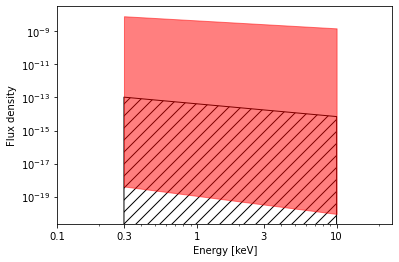

In [33]:
E_range = np.linspace(0.3,10,100)
spectrum = (E_range / 4.135667696e-18)**-(Gamma-1)
spec1 = (E_range / 4.135667696e-18)**-(Gamma+Gammapos-1)
spec2 = (E_range / 4.135667696e-18)**-(Gamma-Gammaneg-1)

plt.fill_between(E_range,[0]*len(E_range),spectrum,fc="none",ec="k",hatch="//")
plt.fill_between(E_range,spec1,spec2,alpha=0.5,color="r")
plt.xlim(1e-1,25)
#plt.ylim(1e-16,1e-4)
plt.yscale("log")
plt.xscale("log")
plt.gca().set_xticks([0.1,0.3,1,3,10])
plt.gca().set_xticklabels([0.1,0.3,1,3,10])
#plt.gca().set_yticks([])
#plt.gca().set_yticklabels([])
plt.xlabel("Energy [keV]")
plt.ylabel("Flux density")

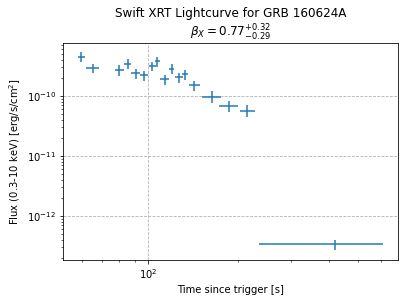

In [34]:
plt.errorbar(fluxdata.Time,fluxdata.Flux,xerr=np.array(fluxdata.Tneg,fluxdata.Tpos).T,yerr=np.array(fluxdata.Fluxneg,fluxdata.Fluxpos).T,linestyle="",capthick=0)
plt.xscale("log")
plt.yscale("log")
plt.title("Swift XRT Lightcurve for GRB %s\n$\\beta_X = %.2f_{-%.2f}^{+%.2f}$" % (burst,Gamma-1.,Gammaneg,Gammapos))
plt.xlabel("Time since trigger [s]")
plt.ylabel("Flux (0.3-10 keV) [erg/s/cm$^2$]")
plt.grid(linestyle="--")
plt.show()

In [15]:
xrt_data = pd.DataFrame(columns=['Time', 'Tpos', 'Tneg', 'Flux', 'Fluxpos', 'Fluxneg', 'GRB'])
for i in new_sGRBs.index:
    GRB_ID = new_sGRBs.loc[i,"GRB"]
    
    try:
        Gamma, Gammapos, Gammaneg = get_BetaX(GRB_ID)
        fluxdata = XRT_lightcurve(GRB_ID)
        xrt_data = xrt_data.append(fluxdata,ignore_index=True)
        
        new_sGRBs.loc[i,"Beta_X"] = Gamma - 1
        new_sGRBs.loc[i,"Beta_X_neg"] = Gammaneg
        new_sGRBs.loc[i,"Beta_X_pos"] = Gammapos
        #print(f"Found {GRB_ID} at index {i}: {Gamma, Gammapos, Gammaneg}")
        
    except:
        print("Failed to retrieve",GRB_ID)

Retrieved 201221D
Retrieved 201006A
Retrieved 200907B
Retrieved 200522A
Retrieved 200411A
Retrieved 191031D
Retrieved 190627A
Failed to retrieve 190610A
Failed to retrieve 190427A
Failed to retrieve 190326A
Retrieved 181123B
Retrieved 180805A
Retrieved 180727A
Failed to retrieve 180718A
Failed to retrieve 180715A
Retrieved 180402A
Retrieved 180204A
Retrieved 170728A
Retrieved 170524A
Retrieved 170428A
Failed to retrieve 170325A
Retrieved 170127B
Failed to retrieve 170112A
Retrieved 161104A
Retrieved 160927A
Retrieved 160821B
Failed to retrieve 160726A
Failed to retrieve 160714A
Retrieved 160624A
Retrieved 160601A
Retrieved 160525B
Retrieved 160411A
Retrieved 160408A
Retrieved 151229A
Failed to retrieve 151228A
Failed to retrieve 151205B
Retrieved 151127A
Retrieved 150831A
Retrieved 150728A
Failed to retrieve 150710A
Retrieved 150423A


## Converting x-ray flux values to spectral flux densities

$$ F_\text{x} = \int_{0.3\text{ keV}}^{10\text{ keV}} F(E)\ dE = \int_{7.254\cdot10^{16}\text{ Hz}}^{2.418\cdot10^{18}\text{ Hz}} F_\nu\ d\nu = A \int_{7.254\cdot10^{16}\text{ Hz}}^{2.418\cdot10^{18}\text{ Hz}} \nu^{-\beta}\ d\nu $$
$$ F_\text{x} = \left.\begin{cases} A\frac{\nu^{1-\beta}}{1-\beta}, & \beta \neq 1 \\ A\ln(\nu), & \beta = 1 \end{cases}\right\}_{7.254\cdot10^{16}\text{ Hz}}^{2.418\cdot10^{18}\text{ Hz}} $$

In [82]:
# grb_id = "160624A"
# i = 291
# beta = AsymmetricUncertainty(0.8,0.1,0.1)
# Fx = AsymmetricUncertainty(xrt_data.loc[i,"Flux"], xrt_data.loc[i,"Fluxpos"], np.abs(xrt_data.loc[i,"Fluxneg"]))
# print("\n",Fx,"\n")
# if beta.value == 1:
#     integral = np.log(10) - np.log(0.3)
# else:
#     integral = (10**(1-beta) - 0.3**(1-beta))/(1-beta)
# A = Fx/integral
# log_mean_freq = 10**np.mean((np.log10(0.3), np.log10(10)))
# spectral_flux = A*log_mean_freq**(-beta)
# spectral_flux *= 1e23/241797944177033445 # convert flux per keV to flux per Hz
# spectral_flux*1e6

for i in xrt_data.index:
    grb_id = xrt_data.loc[i,"GRB"]
    beta = AsymmetricUncertainty(float(new_sGRBs.loc[new_sGRBs["GRB"]==grb_id,"Beta_X"]),
                                 float(new_sGRBs.loc[new_sGRBs["GRB"]==grb_id,"Beta_X_pos"]/1.645), # convert 90% conf to 1-sigma
                                 float(new_sGRBs.loc[new_sGRBs["GRB"]==grb_id,"Beta_X_neg"]/1.645)) # convert 90% conf to 1-sigma
    B = beta.value
    Fx = AsymmetricUncertainty(xrt_data.loc[i,"Flux"], xrt_data.loc[i,"Fluxpos"], np.abs(xrt_data.loc[i,"Fluxneg"]))
    if B == 1:
        integral = np.log(10) - np.log(0.3)
    else:
        integral = (10**(1-B) - 0.3**(1-B))/(1-B)

    log_mean_energy = 10**np.mean((np.log10(0.3),np.log10(10)))

    dfdF = (log_mean_energy**(-B)*(1-B))/(10**(1-B)-0.3**(1-B))
    dfdB = -np.log(log_mean_energy)*log_mean_energy**(-B)*(1-B)*Fx.value/(10**(1-B)-0.3**(1-B)) - log_mean_energy**(-B)*(1-beta.value)*Fx.value*(np.log(0.3)*0.3**(1-B) - np.log(10)*10**(1-B))/((10**(1-beta.value)-0.3**(1-beta.value))**2) - log_mean_energy**(-B)*Fx.value/(10**(1-beta.value)-0.3**(1-beta.value))

    pos_err = np.sqrt(dfdF**2*Fx.plus**2 + dfdB**2*beta.plus**2)
    neg_err = np.sqrt(dfdF**2*Fx.minus**2 + dfdB**2*beta.minus**2)
    result = Fx.value*log_mean_energy**(-B)/integral
    spectral_flux = AsymmetricUncertainty(result,pos_err,neg_err) # erg/s/cm^2/keV
    spectral_flux *= 1e23/241797944177033445 # convert to Jy
    xrt_data.loc[i,"SpecFlux"] = spectral_flux

<ipython-input-82-2d2430000975>:30: RuntimeWarning: invalid value encountered in double_scalars
  dfdF = (log_mean_energy**(-B)*(1-B))/(10**(1-B)-0.3**(1-B))
<ipython-input-82-2d2430000975>:31: RuntimeWarning: invalid value encountered in double_scalars
  dfdB = -np.log(log_mean_energy)*log_mean_energy**(-B)*(1-B)*Fx.value/(10**(1-B)-0.3**(1-B)) - log_mean_energy**(-B)*(1-beta.value)*Fx.value*(np.log(0.3)*0.3**(1-B) - np.log(10)*10**(1-B))/((10**(1-beta.value)-0.3**(1-beta.value))**2) - log_mean_energy**(-B)*Fx.value/(10**(1-beta.value)-0.3**(1-beta.value))
<ipython-input-82-2d2430000975>:31: RuntimeWarning: divide by zero encountered in double_scalars
  dfdB = -np.log(log_mean_energy)*log_mean_energy**(-B)*(1-B)*Fx.value/(10**(1-B)-0.3**(1-B)) - log_mean_energy**(-B)*(1-beta.value)*Fx.value*(np.log(0.3)*0.3**(1-B) - np.log(10)*10**(1-B))/((10**(1-beta.value)-0.3**(1-beta.value))**2) - log_mean_energy**(-B)*Fx.value/(10**(1-beta.value)-0.3**(1-beta.value))


## Load new optical data

In [83]:
new_optical = pd.read_excel("./Required Files/Files for Loading/newData.xlsx")

for col in ["GRB","TriggerNumber","Observatory","Instrument","Source","E(B-V)"]:
    for i in new_optical.index:
        if pd.isna(new_optical.loc[i,col]):
            new_optical.loc[i,col] = new_optical.loc[i-1,col] # deal with merged Excel cells
new_optical.drop(new_optical[new_optical["Magnitude"]=="spectroscopy only"].index,axis=0,inplace=True)
new_optical["mag_w_err"] = [AsymmetricUncertainty(mag,err,err) if isinstance(err,(float,int)) else AsymmetricUncertainty(mag,np.inf,0) for mag,err in new_optical[["Magnitude","Mag error"]].values]

C:\Users\Caden Gobat\Documents\GitHub\dark-GRBs\custom_utils.py:57: RuntimeWarning: invalid value encountered in double_scalars
  self.sign = self.value/np.abs(self.value)


In [137]:
def effective_wavelength(filter_response): # pass a dataframe with columns Wavelength (in Ang), Transmission (in %)
    vega_spec = pd.read_table("http://svo2.cab.inta-csic.es/svo/theory/fps3/morefiles/vega.dat",
                              delimiter=" ",header=None,names=["Wavelength","Flux"])
    vega_function = interpolate.interp1d(vega_spec["Wavelength"],vega_spec["Flux"])
    response_function = interpolate.interp1d(filter_response["Wavelength"],filter_response["Transmission"])
    
    dl = 0.1 # Angstrom
    
    domain = np.arange(filter_response["Wavelength"].min(),filter_response["Wavelength"].max(),dl)
    numerator = np.sum([domain*vega_function(domain)*response_function(domain)*dl])
    denominator = np.sum([vega_function(domain)*response_function(domain)*dl])
    lambda_eff = numerator/denominator
    
#     plt.plot(vega_spec.Wavelength,vega_spec.Flux)
#     plt.yscale("log")
#     plt.twinx()
#     plt.plot(filter_response.Wavelength,filter_response.Transmission)
#     plt.xscale("log")
#     plt.vlines([lambda_eff],0,100,"r")
#     plt.show()

    return lambda_eff

I_filter = pd.read_table("http://www2.lowell.edu/rsch/LMI/I.txt")
rprime_filter = pd.read_table("http://www2.lowell.edu/rsch/LMI/r-band.txt").drop(columns=["T%"],axis=0)
rprime_filter.columns = ["Wavelength","Transmission"]
rprime_filter["Wavelength"] *= 10

effective_wavelength(rprime_filter)

6100.363120460687

## Correcting for extinction

$ A_b = R_b \cdot E_{B-V} $ for an arbitrary band $b$

In [84]:
RbTable = pd.read_csv("./Required Files/Rb.csv") # Table 6 from Schlafly & Finkbeiner (2011)
Rb = interpolate.interp1d(RbTable["lambda_eff"],RbTable["R_b"]) # function that takes a wavelength [Ang] and returns the corresponding R_b value

In [85]:
for i in new_optical.index:    
    try:
        new_optical.loc[i,"Extinction"] = Rb(new_optical.loc[i,"λ_eff"])*new_optical.loc[i,"E(B-V)"]
    except ValueError:
        pass

## Converting optical magnitudes to spectral flux densities

In [86]:
new_optical["Flux (Jy)"] = 3631*10**(-(new_optical["mag_w_err"]-new_optical["Extinction"])/2.5) # AB mag = 0 at F_nu = 3631 Jy

## Putting it all together

In [87]:
display(new_optical[~new_optical["Flux (Jy)"].isna()])
display(xrt_data)

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
0,201006A,998907,Swift,UVOT,white_FC,3885.68,163.0,21.1,3-sigma,GCN 28565,1.27,5.059997,"21.1 (+inf, -0.0)","0.0013932371444571566 (+0.0, -inf)"
1,201006A,998907,Swift,UVOT,u_FC,3520.95,424.5,20.2,3-sigma,GCN 28565,1.27,5.455399,"20.2 (+inf, -0.0)","0.004593946038154898 (+0.0, -inf)"
2,201006A,998907,Swift,UVOT,white,3885.68,813.5,21,3-sigma,GCN 28565,1.27,5.059997,"21.0 (+inf, -0.0)","0.0015276541509540685 (+0.0, -inf)"
3,201006A,998907,Swift,UVOT,v,5411.43,1026.0,18.9,3-sigma,GCN 28565,1.27,3.493137,"18.9 (+inf, -0.0)","0.0024962098350395814 (+0.0, -inf)"
4,201006A,998907,Swift,UVOT,b,4346.25,1038.0,19.8,3-sigma,GCN 28565,1.27,4.587303,"19.8 (+inf, -0.0)","0.0029850227741289445 (+0.0, -inf)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
596,150423A,638808,Johnson,RATIR,z,NaN,91278.0,22.07,3-sigma,GCN 17754,0.03,NaN,"22.07 (+inf, -0.0)","nan (+nan, -nan)"
597,150423A,638808,Akeno,MITSuME,g',4727.80,23744.0,19.4,UL,GCN 17763,0.03,0.098823,"19.4 (+inf, -0.0)","6.91122962026598e-05 (+0.0, -inf)"
598,150423A,638808,Akeno,MITSuME,Rc,6479.38,23744.0,19.3,UL,GCN 17763,0.03,0.064233,"19.3 (+inf, -0.0)","7.340393024633758e-05 (+0.0, -inf)"
599,150423A,638808,Akeno,MITSuME,Ic,7845.53,23744.0,18.4,UL,GCN 17763,0.03,0.047141,"18.4 (+inf, -0.0)","0.00016553232097824908 (+0.0, -inf)"


,Time,Tpos,Tneg,Flux,Fluxpos,Fluxneg,GRB,SpecFlux
0,336.776,23184.683,-239.717,1.802334e-13,4.099744e-14,-4.099744e-14,201221D,9.658686647167336e-09 ± 3.777629808979001e-09
1,153.568,60.668,-62.190,9.464503e-12,2.120667e-12,-2.120667e-12,201006A,6.411812516144993e-07 ± 1.4564323138013472e-07
2,283.514,106.234,-69.278,4.974444e-12,1.289085e-12,-1.289085e-12,201006A,3.369982046979306e-07 ± 8.823011533441419e-08
3,453.501,116.774,-63.753,4.827674e-12,1.253339e-12,-1.253339e-12,201006A,3.270551277294488e-07 ± 8.578031293035484e-08
4,688.759,99.652,-118.485,4.014022e-12,1.043056e-12,-1.043056e-12,201006A,2.719335450274866e-07 ± 7.138692153767167e-08
...,...,...,...,...,...,...,...,...
437,740.288,98.123,-94.940,5.081034e-12,1.133393e-12,-1.133393e-12,150423A,3.0682513894907373e-07 ± 7.562217291552519e-08
438,983.210,191.177,-144.798,3.186325e-12,6.861677e-13,-6.861677e-13,150423A,1.9241057597408912e-07 ± 4.608349130843037e-08
439,4742.155,480.662,-311.650,9.741812e-13,2.616720e-13,-2.616720e-13,150423A,5.8827250049923184e-08 ± 1.6962080024088028e-08
440,5872.965,1047.289,-650.147,4.456341e-13,1.225401e-13,-1.225401e-13,150423A,2.691021790067824e-08 ± 7.919202325142091e-09


In [64]:
max_dt = 0.1
nu_x = 10**np.mean((np.log10(0.3),np.log10(10))) / 4.135667696e-18 # xray frequency [m]
results = pd.DataFrame(columns=["GRB","dt%","nu_o","F_o","nu_x","F_x","B_ox"])
for i_o in new_optical.index: # for each optical data point
    t_o = new_optical.loc[i_o,"Time (s)"] # optical observation time
    F_o = new_optical.loc[i_o,"Flux (Jy)"] # optical flux
    nu_o = 299792458/float(new_optical.loc[i_o,"λ_eff"]/1e10) # optical frequency [m]
    for i_x in xrt_data.index: # for each x-ray data point
        t_x = float(xrt_data.loc[i_x,"Time"]) # x-ray observation time
        dt = np.abs(t_o-t_x)/t_o # time difference
        if new_optical.loc[i_o,"GRB"] == xrt_data.loc[i_x,"GRB"] and dt <= max_dt: # if time separation is too large or if they don't correspond to the same GRB
            F_x = xrt_data.loc[i_x,"SpecFlux"]
            Beta_ox = -np.log10(F_x/F_o)/np.log10(nu_x/nu_o)
            if pd.notna(Beta_ox):
                results = results.append({"GRB":new_optical.loc[i_o,"GRB"], "dt%":dt,
                       "nu_o":nu_o, "F_o":F_o, "nu_x":nu_x, "F_x":F_x,
                       "B_ox":Beta_ox},ignore_index=True)
        else: # this means they match and are within the allowable time separation
            pass

# get the previously retreived x-ray spectral indices for comparison
for i in results.index:
    grb_id = results.loc[i,"GRB"]
    results.loc[i,"B_x"] = AsymmetricUncertainty(*new_sGRBs.loc[new_sGRBs["GRB"]==grb_id,["Beta_X","Beta_X_pos","Beta_X_neg"]].values.flatten())
    
# # only accept the closest in time for each GRB
# for grb_id in results["GRB"].unique():
#     working = results[results["GRB"]==grb_id]
#     closest_time = working["dt%"].min()
#     results.drop(working[working["dt%"] != closest_time].index, axis=0, inplace=True)

divided 6.411812516144993e-07 ± 1.4564323138013472e-07 by 0.0013932371444571566 (+0.0, -inf) = 0.0004602097023937164 (+inf, -0.00010345022092935908)
logged 0.0004602097023937164 (+inf, -0.00010345022092935908) = -3.337044229536054 (+inf, -0.09762475642648766)
divided 3.337044229536054 (+0.09762475642648766, -inf) by 2.7346613208242623 ± 0.0 = 1.2202769696286286 (+0.03569902996143679, -inf)
divided 3.270551277294488e-07 ± 8.578031293035484e-08 by 0.004593946038154898 (+0.0, -inf) = 7.119263591977377e-05 (+inf, -1.8527211992952727e-05)
logged 7.119263591977377e-05 (+inf, -1.8527211992952727e-05) = -4.1475649269363 (+inf, -0.11302104255078249)
divided 4.1475649269363 (+0.11302104255078249, -inf) by 2.6918541466540935 ± 0.0 = 1.540783675850944 (+0.041986317383229985, -inf)
divided 2.2111435459003e-07 ± 5.8360095253541474e-08 by 0.0015276541509540685 (+0.0, -inf) = 0.0001447411080917347 (+inf, -3.7908973159719973e-05)
logged 0.0001447411080917347 (+inf, -3.7908973159719973e-05) = -3.8394081

divided 4.3741476513913e-08 (+nan, -nan) by nan (+nan, -nan) = nan (+nan, -nan)
logged nan (+nan, -nan) = nan (+nan, -nan)
divided nan (+nan, -nan) by nan ± 0.0 = nan (+nan, -nan)
divided 5.659416128765437e-08 (+nan, -nan) by nan (+nan, -nan) = nan (+nan, -nan)
logged nan (+nan, -nan) = nan (+nan, -nan)
divided nan (+nan, -nan) by nan ± 0.0 = nan (+nan, -nan)
divided 5.659416128765437e-08 (+nan, -nan) by nan (+nan, -nan) = nan (+nan, -nan)
logged nan (+nan, -nan) = nan (+nan, -nan)
divided nan (+nan, -nan) by nan ± 0.0 = nan (+nan, -nan)
divided 2.835477382791366e-08 (+nan, -nan) by nan (+nan, -nan) = nan (+nan, -nan)
logged nan (+nan, -nan) = nan (+nan, -nan)
divided nan (+nan, -nan) by nan ± 0.0 = nan (+nan, -nan)
divided 4.672388096323183e-07 (+nan, -nan) by nan (+nan, -nan) = nan (+nan, -nan)
logged nan (+nan, -nan) = nan (+nan, -nan)
divided nan (+nan, -nan) by nan ± 0.0 = nan (+nan, -nan)
divided 3.1736164875613554e-07 (+nan, -nan) by nan (+nan, -nan) = nan (+nan, -nan)
logged na

logged 0.0033008595872444715 (+inf, -0.0006367785935953546) = -2.4813729493994363 (+inf, -0.08378103402557541)
divided 2.4813729493994363 (+0.08378103402557541, -inf) by 2.6918541466540935 ± 0.0 = 0.9218080973977435 (+0.031123912909513732, -inf)
divided 1.4688153266756615e-07 ± 3.841693061456888e-08 by nan (+nan, -nan) = nan (+nan, -nan)
logged nan (+nan, -nan) = nan (+nan, -nan)
divided nan (+nan, -nan) by 2.4965614986972624 ± 0.0 = nan (+nan, -nan)
divided 1.67733281565433e-07 ± 4.4088823726151444e-08 by nan (+nan, -nan) = nan (+nan, -nan)
logged nan (+nan, -nan) = nan (+nan, -nan)
divided nan (+nan, -nan) by 2.4965614986972624 ± 0.0 = nan (+nan, -nan)
divided 1.6737992123973027e-07 ± 4.011032946902463e-08 by nan (+nan, -nan) = nan (+nan, -nan)
logged nan (+nan, -nan) = nan (+nan, -nan)
divided nan (+nan, -nan) by 2.4965614986972624 ± 0.0 = nan (+nan, -nan)
divided 6.879651180273727e-08 ± 1.532725569595009e-08 by 0.0004918014749587589 (+nan, -nan) = 0.0001398867537119655 (+nan, -nan)

divided 5.971102945247393e-05 (+9.137812124143351e-06, -9.154778398286056e-06) by nan (+nan, -nan) = nan (+nan, -nan)
logged nan (+nan, -nan) = nan (+nan, -nan)
divided nan (+nan, -nan) by nan ± 0.0 = nan (+nan, -nan)
divided 5.0573573272055984e-05 (+8.045498812771146e-06, -8.05932140898375e-06) by nan (+nan, -nan) = nan (+nan, -nan)
logged nan (+nan, -nan) = nan (+nan, -nan)
divided nan (+nan, -nan) by nan ± 0.0 = nan (+nan, -nan)
divided 4.8512568879064345e-05 (+7.424069013775399e-06, -7.437851635277016e-06) by nan (+nan, -nan) = nan (+nan, -nan)
logged nan (+nan, -nan) = nan (+nan, -nan)
divided nan (+nan, -nan) by nan ± 0.0 = nan (+nan, -nan)
divided 5.294596781103382e-05 (+8.422908652886152e-06, -8.437381794181772e-06) by nan (+nan, -nan) = nan (+nan, -nan)
logged nan (+nan, -nan) = nan (+nan, -nan)
divided nan (+nan, -nan) by nan ± 0.0 = nan (+nan, -nan)
divided 4.974078516495971e-05 (+7.760233997706826e-06, -7.774098283095516e-06) by nan (+nan, -nan) = nan (+nan, -nan)
logged na

divided 2.8882226896577043e-05 ± 4.419962546432338e-06 by nan (+nan, -nan) = nan (+nan, -nan)
logged nan (+nan, -nan) = nan (+nan, -nan)
divided nan (+nan, -nan) by nan ± 0.0 = nan (+nan, -nan)
divided 2.1354029230999778e-05 ± 3.968087917537154e-06 by nan (+nan, -nan) = nan (+nan, -nan)
logged nan (+nan, -nan) = nan (+nan, -nan)
divided nan (+nan, -nan) by nan ± 0.0 = nan (+nan, -nan)
divided 3.0465379515762506e-05 ± 4.75300904353058e-06 by nan (+nan, -nan) = nan (+nan, -nan)
logged nan (+nan, -nan) = nan (+nan, -nan)
divided nan (+nan, -nan) by nan ± 0.0 = nan (+nan, -nan)
divided 2.7106890728313435e-05 ± 4.148275424898968e-06 by nan (+nan, -nan) = nan (+nan, -nan)
logged nan (+nan, -nan) = nan (+nan, -nan)
divided nan (+nan, -nan) by nan ± 0.0 = nan (+nan, -nan)
divided 2.9295566608330313e-05 ± 4.608045899555067e-06 by nan (+nan, -nan) = nan (+nan, -nan)
logged nan (+nan, -nan) = nan (+nan, -nan)
divided nan (+nan, -nan) by nan ± 0.0 = nan (+nan, -nan)
divided 2.3696870831439618e-05 

divided 4.7499967307159116e-05 (+7.269106537516004e-06, -7.2826035961124405e-06) by 1.58383975914078e-05 (+0.0, -inf) = 2.999038699023912 (+inf, -0.4598068430901869)
logged 2.999038699023912 (+inf, -0.4598068430901869) = 0.47698206984892494 (+inf, -0.06658519436925422)
divided -0.47698206984892494 (+0.06658519436925422, -inf) by 2.7346613208242623 ± 0.0 = -0.17442089307978964 (+0.02434860721589633, -inf)
divided 4.475428856739492e-05 (+6.982272179053558e-06, -6.994746789325618e-06) by 1.58383975914078e-05 (+0.0, -inf) = 2.825682857694755 (+inf, -0.4416322263004819)
logged 2.825682857694755 (+inf, -0.4416322263004819) = 0.45112341693145674 (+inf, -0.06787684555280213)
divided -0.45112341693145674 (+0.06787684555280213, -inf) by 2.7346613208242623 ± 0.0 = -0.16496500443992176 (+0.024820933047878545, -inf)
divided 4.258492049086699e-05 (+6.774623855434627e-06, -6.786263020075349e-06) by 1.58383975914078e-05 (+0.0, -inf) = 2.688713946287657 (+inf, -0.42846904056486373)
logged 2.68871394628

divided 3.7143796392448516e-08 ± 8.487870243729455e-09 by 4.255226176314292e-05 (+0.0, -inf) = 0.0008728982867984939 (+inf, -0.00018725792321500222)
logged 0.0008728982867984939 (+inf, -0.00018725792321500222) = -3.059036358878252 (+inf, -0.09316673428608982)
divided 3.059036358878252 (+0.09316673428608982, -inf) by 2.783308992522676 ± 0.0 = 1.0990645907789305 (+0.03347337091799045, -inf)
divided 3.7143796392448516e-08 ± 8.487870243729455e-09 by 3.356869474225643e-05 (+0.0, -inf) = 0.0011065010623034959 (+inf, -0.00023737140294099145)
logged 0.0011065010623034959 (+inf, -0.00023737140294099145) = -2.956048164789299 (+inf, -0.0931667342860898)
divided 2.956048164789299 (+0.0931667342860898, -inf) by 2.5739994529519357 ± 0.0 = 1.148426104519649 (+0.03619532015799132, -inf)
divided 3.7143796392448516e-08 ± 8.487870243729455e-09 by nan (+nan, -nan) = nan (+nan, -nan)
logged nan (+nan, -nan) = nan (+nan, -nan)
divided nan (+nan, -nan) by 2.4965614986972624 ± 0.0 = nan (+nan, -nan)
divided 3

divided 1.6103208560151216e-07 ± 4.19796231732509e-08 by nan (+nan, -nan) = nan (+nan, -nan)
logged nan (+nan, -nan) = nan (+nan, -nan)
divided nan (+nan, -nan) by nan ± 0.0 = nan (+nan, -nan)
divided 3.304343000657979e-05 (+6.368967293631944e-06, -6.14799675096741e-06) by 3.430308908661502e-05 (+0.0, -inf) = 0.9632785526442065 (+inf, -0.1792257465630506)
logged 0.9632785526442065 (+inf, -0.1792257465630506) = -0.016248109154263685 (+inf, -0.08080399229658039)
divided 0.016248109154263685 (+0.08080399229658039, -inf) by 2.7346613208242623 ± 0.0 = 0.005941543484941051 (+0.029548080298376776, -inf)
divided 2.3517966056665865e-05 (+4.668107500473103e-06, -4.515542845319403e-06) by 3.430308908661502e-05 (+0.0, -inf) = 0.6855932419754732 (+inf, -0.13163662415118632)
logged 0.6855932419754732 (+inf, -0.13163662415118632) = -0.1639334719880464 (+inf, -0.08338626460276244)
divided 0.1639334719880464 (+0.08338626460276244, -inf) by 2.7346613208242623 ± 0.0 = 0.05994653551418013 (+0.030492355293

In [65]:
results

,GRB,dt%,nu_o,F_o,nu_x,F_x,B_ox,B_x
0,201006A,0.057865,7.715315e+14,"0.0013932371444571566 (+0.0, -inf)",4.188080e+17,6.411812516144993e-07 ± 1.4564323138013472e-07,"1.2202769696286286 (+0.03569902996143679, -inf)","1.1 (+0.6, -0.29)"
1,201006A,0.068318,8.514533e+14,"0.004593946038154898 (+0.0, -inf)",4.188080e+17,3.270551277294488e-07 ± 8.578031293035484e-08,"1.540783675850944 (+0.041986317383229985, -inf)","1.1 (+0.6, -0.29)"
2,201006A,0.094127,7.715315e+14,"0.0015276541509540685 (+0.0, -inf)",4.188080e+17,2.2111435459003e-07 ± 5.8360095253541474e-08,"1.4039793804228844 (+0.041594019494683054, -inf)","1.1 (+0.6, -0.29)"
3,200907B,0.093918,7.715315e+14,"0.0002356042664976089 (+0.0, -inf)",4.188080e+17,"3.877164229713178e-06 (+nan, -nan)","0.6522449196179292 (+nan, -nan)","1.0 (+0.5, -0.29)"
4,200907B,0.082500,5.539986e+14,"0.0014162784691803699 (+0.0, -inf)",4.188080e+17,"8.548677487790112e-08 (+nan, -nan)","1.4657774660395206 (+nan, -nan)","1.0 (+0.5, -0.29)"
...,...,...,...,...,...,...,...,...
273,150831A,0.067452,8.514533e+14,"6.152224884941876e-05 (+0.0, -inf)",4.188080e+17,6.110291422465932e-07 ± 1.4276424216231488e-07,"0.7440857375857574 (+0.03681056933342944, -inf)","0.8 (+0.5, -0.29)"
274,150423A,0.027276,NaN,"nan (+nan, -nan)",4.188080e+17,1.1765120554102808e-06 ± 2.9215929262413635e-07,"nan (+nan, -nan)","0.51 (+0.36, -0.29)"
275,150423A,0.041306,NaN,"nan (+nan, -nan)",4.188080e+17,2.691021790067824e-08 ± 7.919202325142091e-09,"nan (+nan, -nan)","0.51 (+0.36, -0.29)"
276,150423A,0.017586,8.514533e+14,"3.4007391963081324e-05 (+0.0, -inf)",4.188080e+17,3.7749342560129827e-07 ± 9.253562030872172e-08,"0.7261403583393575 (+0.03825810629493198, -inf)","0.51 (+0.36, -0.29)"


In [77]:
for i in results.index:
    if results.loc[i,"B_ox"]<<0.5:
        results.loc[i,"Jak_dark"] = True
    else:
        results.loc[i,"Jak_dark"] = False
    if results.loc[i,"B_ox"] << results.loc[i,"B_x"]-0.5:
        results.loc[i,"vdH_dark"] = True
    else:
        results.loc[i,"vdH_dark"] = False

subtracted 0.5 ± 0.0 from 1.1 (+0.6, -0.29) = 0.6000000000000001 (+0.6, -0.29)
subtracted 0.5 ± 0.0 from 1.1 (+0.6, -0.29) = 0.6000000000000001 (+0.6, -0.29)
subtracted 0.5 ± 0.0 from 1.1 (+0.6, -0.29) = 0.6000000000000001 (+0.6, -0.29)
subtracted 0.5 ± 0.0 from 1.0 (+0.5, -0.29) = 0.5 (+0.5, -0.29)
subtracted 0.5 ± 0.0 from 1.0 (+0.5, -0.29) = 0.5 (+0.5, -0.29)
subtracted 0.5 ± 0.0 from 1.0 (+0.5, -0.29) = 0.5 (+0.5, -0.29)
subtracted 0.5 ± 0.0 from 0.3500000000000001 (+0.44, -0.29) = -0.1499999999999999 (+0.44, -0.29)
subtracted 0.5 ± 0.0 from 0.3500000000000001 (+0.44, -0.29) = -0.1499999999999999 (+0.44, -0.29)
subtracted 0.5 ± 0.0 from 0.3500000000000001 (+0.44, -0.29) = -0.1499999999999999 (+0.44, -0.29)
subtracted 0.5 ± 0.0 from 0.3500000000000001 (+0.44, -0.29) = -0.1499999999999999 (+0.44, -0.29)
subtracted 0.5 ± 0.0 from 0.72 (+0.23, -0.29) = 0.21999999999999997 (+0.23, -0.29)
subtracted 0.5 ± 0.0 from 0.72 (+0.23, -0.29) = 0.21999999999999997 (+0.23, -0.29)
subtracted 0.5 ± 

subtracted 0.5 ± 0.0 from 1.2000000000000002 (+0.28, -0.29) = 0.7000000000000002 (+0.28, -0.29)
subtracted 0.5 ± 0.0 from 1.2000000000000002 (+0.28, -0.29) = 0.7000000000000002 (+0.28, -0.29)
subtracted 0.5 ± 0.0 from 1.2000000000000002 (+0.28, -0.29) = 0.7000000000000002 (+0.28, -0.29)
subtracted 0.5 ± 0.0 from 1.2000000000000002 (+0.28, -0.29) = 0.7000000000000002 (+0.28, -0.29)
subtracted 0.5 ± 0.0 from 1.2000000000000002 (+0.28, -0.29) = 0.7000000000000002 (+0.28, -0.29)
subtracted 0.5 ± 0.0 from 1.2000000000000002 (+0.28, -0.29) = 0.7000000000000002 (+0.28, -0.29)
subtracted 0.5 ± 0.0 from 1.2000000000000002 (+0.28, -0.29) = 0.7000000000000002 (+0.28, -0.29)
subtracted 0.5 ± 0.0 from 1.2000000000000002 (+0.28, -0.29) = 0.7000000000000002 (+0.28, -0.29)
subtracted 0.5 ± 0.0 from 1.2000000000000002 (+0.28, -0.29) = 0.7000000000000002 (+0.28, -0.29)
subtracted 0.5 ± 0.0 from 1.2000000000000002 (+0.28, -0.29) = 0.7000000000000002 (+0.28, -0.29)
subtracted 0.5 ± 0.0 from 1.200000000000

In [80]:
results.loc[results["Jak_dark"] | results["vdH_dark"],:]

,GRB,dt%,nu_o,F_o,nu_x,F_x,B_ox,B_x,Jak_dark,vdH_dark
10,200411A,0.024797,7.715315e+14,"1.8702525075288152e-05 (+0.0, -inf)",4.188080e+17,9.332425136416544e-06 (+2.0713866665451478e-06...,"0.11039967861455506 (+0.0355764827391868, -inf)","0.72 (+0.23, -0.29)",True,False
19,191031D,0.075833,7.715315e+14,"2.3308924547633908e-05 (+0.0, -inf)",4.188080e+17,1.5476334656695069e-06 (+2.5255503587570384e-0...,"0.43071297890914295 (+0.03657013077563423, -inf)","1.4 (+6.7, -0.29)",True,True
42,181123B,0.059577,7.715315e+14,"3.074944234689961e-05 (+0.0, -inf)",4.188080e+17,1.8352830998523974e-06 ± 4.1276093872005547e-07,"0.44763648402206235 (+0.03571508962005919, -inf)","1.0499999999999998 (+0.3, -0.29)",True,False
46,180727A,0.011414,7.715315e+14,"1.705690559198853e-05 (+0.0, -inf)",4.188080e+17,2.053967938070219e-06 ± 4.7371711197633177e-07,"0.3361683505769887 (+0.036226193551892986, -inf)","0.8 (+0.4, -0.29)",True,False
58,180204A,0.081281,7.715315e+14,"3.9755409642269e-05 (+0.0, -inf)",4.188080e+17,1.031858780415616e-05 ± 2.2816463719242862e-06,"0.2142042103286411 (+0.03512132051279298, -inf)","0.97 (+0.21, -0.29)",True,False
59,180204A,0.098263,8.514533e+14,"5.913571370677091e-05 (+0.0, -inf)",4.188080e+17,4.379411779185037e-06 ± 9.898988975704718e-07,"0.41994625225969745 (+0.03647263839177463, -inf)","0.97 (+0.21, -0.29)",True,False
190,160821B,0.093358,7.715315e+14,"1.58383975914078e-05 (+0.0, -inf)",4.188080e+17,"5.220906421956912e-05 (+7.989759279074338e-06,...","-0.18943284285368908 (+0.024348610060609954, -...","1.2000000000000002 (+0.28, -0.29)",True,True
191,160821B,0.080755,7.715315e+14,"1.58383975914078e-05 (+0.0, -inf)",4.188080e+17,5.3743478270399417e-05 (+8.224577027488323e-06...,"-0.19403299618145306 (+0.02434860451241118, -inf)","1.2000000000000002 (+0.28, -0.29)",True,True
192,160821B,0.069026,7.715315e+14,"1.58383975914078e-05 (+0.0, -inf)",4.188080e+17,6.673245945413851e-05 (+1.0411164103767072e-05...,"-0.22841069409199952 (+0.02482092803566095, -inf)","1.2000000000000002 (+0.28, -0.29)",True,True
193,160821B,0.056510,7.715315e+14,"1.58383975914078e-05 (+0.0, -inf)",4.188080e+17,"4.525851676427244e-05 (+7.199953509367625e-06,...","-0.16674425918500183 (+0.025307872583975623, -...","1.2000000000000002 (+0.28, -0.29)",True,True


In [26]:
def simulate_spectrum(idx):
    inter_freqs = np.linspace(results.loc[idx,"nu_o"],0.3/4.135667696e-18,100)
    xray_freqs = np.linspace(0.3,10,100)/4.135667696e-18
    
    ox_spec = inter_freqs**(-results.loc[idx,"B_ox"].value)
    ox_spec = ox_spec * (results.loc[idx,"F_o"]/ox_spec[0])
    x_spec = xray_freqs**(-results.loc[idx,"B_x"])
    x_spec = x_spec * (ox_spec[-1]/x_spec[0])
    plt.plot(inter_freqs,ox_spec,label=r"$\beta_{ox}=%f$"%(-results.loc[idx,"B_ox"]))
    plt.plot(xray_freqs,x_spec,label=r"$\beta_x=%f$"%(-results.loc[idx,"B_x"]))
    plt.vlines([10**np.mean((np.log10(0.3),np.log10(10))) / 4.135667696e-18],0,10**np.log10((x_spec.max()+x_spec.min())/2),"k",linestyle="--")
    plt.xscale("log")
    plt.yscale("log")
    plt.legend()
    #plt.gca().set_yticklabels([])
    plt.show()

divided 1.8702525075288152e-05 (+0.0, -inf) by 0.022721706166192606 ± 0.0 = 0.0008231127072277454 (+0.0, -inf)
multiplied 0.022721706166192606 ± 0.0 by 0.0008231127072277454 (+0.0, -inf) = 1.8702525075288152e-05 (+0.0, -inf)
multiplied 0.021119207416547332 ± 0.0 by 0.0008231127072277454 (+0.0, -inf) = 1.7383487991138552e-05 (+0.0, -inf)
multiplied 0.020217967176229104 ± 0.0 by 0.0008231127072277454 (+0.0, -inf) = 1.6641665697067632e-05 (+0.0, -inf)
multiplied 0.019597307496740997 ± 0.0 by 0.0008231127072277454 (+0.0, -inf) = 1.6130792828017074e-05 (+0.0, -inf)
multiplied 0.01912711554475098 ± 0.0 by 0.0008231127072277454 (+0.0, -inf) = 1.574377185749787e-05 (+0.0, -inf)
multiplied 0.018750352543529008 ± 0.0 by 0.0008231127072277454 (+0.0, -inf) = 1.5433653443578804e-05 (+0.0, -inf)
multiplied 0.018437039853150598 ± 0.0 by 0.0008231127072277454 (+0.0, -inf) = 1.5175761786792623e-05 (+0.0, -inf)
multiplied 0.01816952065903122 ± 0.0 by 0.0008231127072277454 (+0.0, -inf) = 1.49555633386856

raised 1.920469637854637e+18 ± 0.0 to -0.72 (+0.29, -0.23) = 6.854040073075771e-14 ± 8.367918919619828e-13
raised 1.9441610476056102e+18 ± 0.0 to -0.72 (+0.29, -0.23) = 6.79380048921868e-14 ± 8.296789604289027e-13
raised 1.9678524573565832e+18 ± 0.0 to -0.72 (+0.29, -0.23) = 6.734810431796182e-14 ± 8.227114848873681e-13
raised 1.991543867107556e+18 ± 0.0 to -0.72 (+0.29, -0.23) = 6.677029401769531e-14 ± 8.158847933635415e-13
raised 2.015235276858529e+18 ± 0.0 to -0.72 (+0.29, -0.23) = 6.620418674187172e-14 ± 8.09194417190028e-13
raised 2.038926686609502e+18 ± 0.0 to -0.72 (+0.29, -0.23) = 6.564941200725878e-14 ± 8.026360798955231e-13
raised 2.062618096360475e+18 ± 0.0 to -0.72 (+0.29, -0.23) = 6.510561518645408e-14 ± 7.962056868224623e-13
raised 2.0863095061114476e+18 ± 0.0 to -0.72 (+0.29, -0.23) = 6.457245665666509e-14 ± 7.898993154172333e-13
raised 2.1100009158624205e+18 ± 0.0 to -0.72 (+0.29, -0.23) = 6.40496110032459e-14 ± 7.837132061423088e-13
raised 2.1336923256133934e+18 ± 0.0 

C:\Users\Caden Gobat\Documents\GitHub\dark-GRBs\custom_utils.py:57: RuntimeWarning: invalid value encountered in double_scalars
  self.sign = self.value/np.abs(self.value)


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

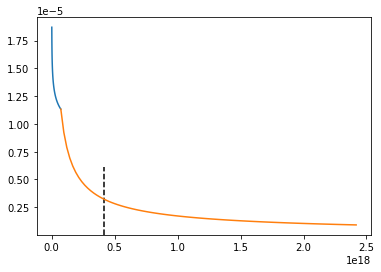

In [27]:
simulate_spectrum(10)

In [76]:
print(AsymmetricUncertainty(5,0.5,0.3) >  AsymmetricUncertainty(4,0.8,0.5))
print(AsymmetricUncertainty(5,0.5,0.3) >> AsymmetricUncertainty(4,0.8,0.5))

True
False


In [ ]:
display(results.loc[425,])
E_range = np.logspace(np.log10(0.3),np.log10(10),100)

E_o = results.loc[421,"nu_o"]*6.62607015e-34/1.6021773E-16
E_x = results.loc[421,"nu_x"]*6.62607015e-34/1.6021773E-16
F_o = results.loc[421,"F_o"]
F_x = results.loc[421,"F_x"]
spectrum = E_range**-beta.value
scale = F_x.value/spectrum[len(spectrum)//2]
spectrum = scale * spectrum
spec1 = E_range**-beta.maximum
scale1 = F_x.value/spec1[len(spec1)//2]
spec1 = scale1 * spec1
spec2 = E_range**-beta.minimum
scale2 = F_x.value/spec2[len(spec2)//2]
spec2 = scale2 * spec2

plt.style.use("seaborn-poster")
fig,ax = plt.subplots(figsize=(9,6),facecolor="none")

plt.fill_between([0.003262755,0.0016531293],[1,1],alpha=0.5,fc="darkorange",label="Optical band")
plt.fill_between([0.3,10],[1,1],alpha=0.5,fc="turquoise",label="X-ray band")
plt.errorbar([E_o,E_x],[F_o.value,F_x.value],xerr=[(0,E_x-0.3),(0,10-E_x)],
             yerr=[(0.000013,F_x.value-1e-6),(0,F_o.value-F_x.value)],
             uplims=[1,0],capsize=0,elinewidth=2,marker=".",linestyle=":",color="k",label="Observed flux")
plt.fill_between(E_range,spectrum,fc="none",ec="k",hatch="/")
plt.fill_between(E_range,spec1,spec2,color="slateblue",label=r"$\beta_x=0.77_{-0.29}^{+0.32}$")
plt.text(1.1e-2,1.1e-5,r"$F\propto\nu^{(-\beta_{ox}\approx\mathrm{-0.2})}$",size=18,rotation=-13)

plt.legend(loc="upper left",bbox_to_anchor=(1,1))
plt.grid(linestyle="--")
plt.xlim(1e-3,30)
plt.ylim(5e-7,2e-4)
plt.yscale("log")
plt.xscale("log")
plt.gca().set_xticks([0.001,0.01,0.3,10])
plt.gca().set_xticklabels(["$10^{-3}$","$10^{-2}$",0.3,10])
plt.title(r"Example: GRB 160624A, $t\approx160$ s")
plt.xlabel("Energy [keV]")
plt.ylabel("Flux density [Jy]")
fig.savefig("./Required Files/Generated Files (Python)/160624A.png",bbox_inches="tight",dpi=300)